In [549]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV

# 1. Знакомство с данными и их предобработка

In [552]:
# Загружаем датасет
data = pd.read_csv('Mobile Price Prediction.csv')
data.head()

,Product_id,Price,Sale,weight,resoloution,ppi,cpu core,cpu freq,internal mem,ram,RearCam,Front_Cam,battery,thickness
0,203,2357,10,135.0,5.2,424,8,1.35,16.0,3.000,13.00,8.0,2610,7.4
1,880,1749,10,125.0,4.0,233,2,1.30,4.0,1.000,3.15,0.0,1700,9.9
2,40,1916,10,110.0,4.7,312,4,1.20,8.0,1.500,13.00,5.0,2000,7.6
3,99,1315,11,118.5,4.0,233,2,1.30,4.0,0.512,3.15,0.0,1400,11.0
4,880,1749,11,125.0,4.0,233,2,1.30,4.0,1.000,3.15,0.0,1700,9.9


In [554]:
# Посмотрим основную информацию по данным
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161 entries, 0 to 160
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Product_id    161 non-null    int64  
 1   Price         161 non-null    int64  
 2   Sale          161 non-null    int64  
 3   weight        161 non-null    float64
 4   resoloution   161 non-null    float64
 5   ppi           161 non-null    int64  
 6   cpu core      161 non-null    int64  
 7   cpu freq      161 non-null    float64
 8   internal mem  161 non-null    float64
 9   ram           161 non-null    float64
 10  RearCam       161 non-null    float64
 11  Front_Cam     161 non-null    float64
 12  battery       161 non-null    int64  
 13  thickness     161 non-null    float64
dtypes: float64(8), int64(6)
memory usage: 17.7 KB


Определим, какие столбцы, что означают:

Product_id - Идентификатор каждого мобильного телефона  

Price - Цена каждого мобильного телефона

Sale - Количество продаж

weight - Вес каждого мобильного телефона

resoloution - Разрешение каждого мобильного телефона

ppi - Плотность пикселей телефона

cpu core - Тип ядра ЦП в каждом мобильном телефоне  

cpu freq - Частота ЦП в каждом мобильном телефоне

internal mem - Внутренняя память каждого мобильного телефона

ram - Оперативная память каждого мобильного телефона

RearCam - Задняя камера   

Front_Cam - Передняя камера

battery - Батарея

thickness - Толщина

Все типы данных соответсвуют необходимым и пропуски отсутсвуют. Проверим данные на наличие дубликатов.

In [558]:
data.duplicated().sum()

0

Дубликатов не найдено. Проверим пропущенные значения.

In [561]:
data.isnull().sum()

Product_id      0
Price           0
Sale            0
weight          0
resoloution     0
ppi             0
cpu core        0
cpu freq        0
internal mem    0
ram             0
RearCam         0
Front_Cam       0
battery         0
thickness       0
dtype: int64

Пропусков нет. Обработаем названия столбцов.

In [564]:
# Приведем названия столбцов к нижнему регистру
col = ['_'.join(i.lower().split()) for i in list(data.columns)]

In [566]:
data.columns = col

In [568]:
data.head()

,product_id,price,sale,weight,resoloution,ppi,cpu_core,cpu_freq,internal_mem,ram,rearcam,front_cam,battery,thickness
0,203,2357,10,135.0,5.2,424,8,1.35,16.0,3.000,13.00,8.0,2610,7.4
1,880,1749,10,125.0,4.0,233,2,1.30,4.0,1.000,3.15,0.0,1700,9.9
2,40,1916,10,110.0,4.7,312,4,1.20,8.0,1.500,13.00,5.0,2000,7.6
3,99,1315,11,118.5,4.0,233,2,1.30,4.0,0.512,3.15,0.0,1400,11.0
4,880,1749,11,125.0,4.0,233,2,1.30,4.0,1.000,3.15,0.0,1700,9.9


Проверим данные на выбросы.

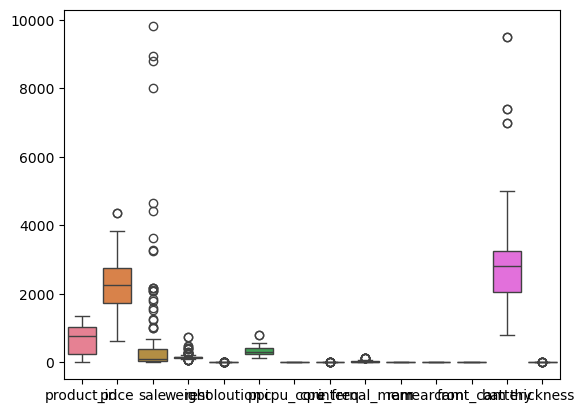

In [571]:
# Построим боксплот
sns.boxplot(data=data)
plt.show()

In [573]:
# Удалим выбросы
for c in col:
    q3 = data[c].describe()['75%']    # 75-ая квантиль
    q1 = data[c].describe()['25%']    # 25-ая квантиль
    iqr = q3-q1    # длина промежутка
    iqr_min = q1 - 1.5 * iqr    # нижняя граница
    iqr_max = q3 + 1.5 * iqr    # верхняя граница
    data = data[(iqr_min <= data[c]) & (data[c] <= iqr_max)]    # перезаписываем датасет без выбросов

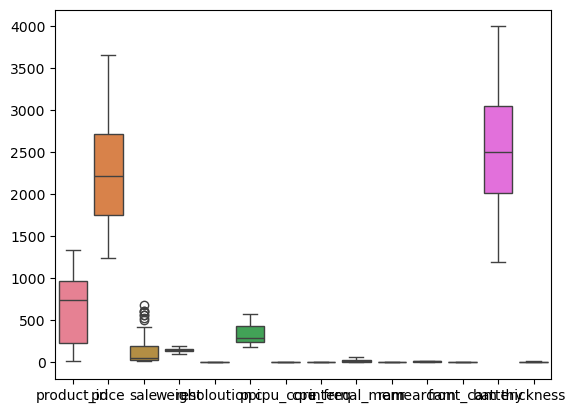

In [575]:
# Проверяем боксплот
sns.boxplot(data=data)
plt.show()

Остались выбросы у sale. Попробуем удалить их.

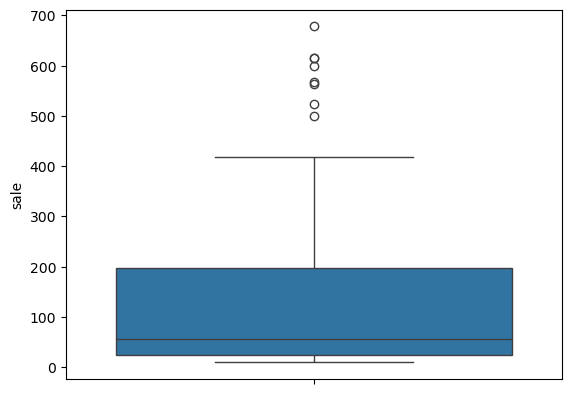

In [578]:
# Посмотрим боксплот
sns.boxplot(data=data['sale'])
plt.show()

In [580]:
#Напишем функцию
def ejection (col):
    q75 = np.percentile(data[col], 75)
    q25 = np.percentile(data[col], 25)
    iqr = q75 - q25
    ejection_h = q75 + 1.5 * iqr
    ejection_l = q25 - 1.5 * iqr
    ejection_count = len(data[(data[col] > ejection_h) | (data[col] < ejection_l)])
    ejection_perc = ejection_count / len(data) * 100
    return(ejection_h, ejection_l, ejection_count, ejection_perc)

In [606]:
#Посмотрим количество выбросов
ejection_values = ejection('sale')
ejection_count = ejection_values[2]
ejection_count

1

In [608]:
# Выше мы нашли число выбросов, перевернем условия, чтобы отфильтровать датасет без них
data = data[(data['sale'] < ejection('sale')[0]) & (data['sale'] > ejection('sale')[1])]
data = data.reset_index(drop=True)
data.head()

,product_id,price,sale,weight,resoloution,ppi,cpu_core,cpu_freq,internal_mem,ram,rearcam,front_cam,battery,thickness
0,203,2357,10,135.0,5.2,424,8,1.35,16.0,3.000,13.00,8.0,2610,7.4
1,880,1749,10,125.0,4.0,233,2,1.30,4.0,1.000,3.15,0.0,1700,9.9
2,40,1916,10,110.0,4.7,312,4,1.20,8.0,1.500,13.00,5.0,2000,7.6
3,99,1315,11,118.5,4.0,233,2,1.30,4.0,0.512,3.15,0.0,1400,11.0
4,880,1749,11,125.0,4.0,233,2,1.30,4.0,1.000,3.15,0.0,1700,9.9


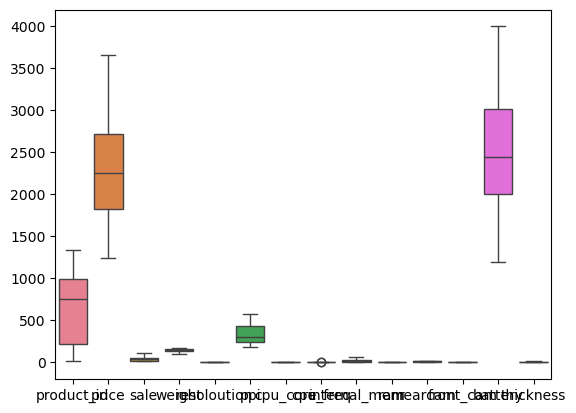

In [610]:
# Проверяем боксплот
sns.boxplot(data=data)
plt.show()

Теперь видим выбросы у cpu_freq, удалим их.

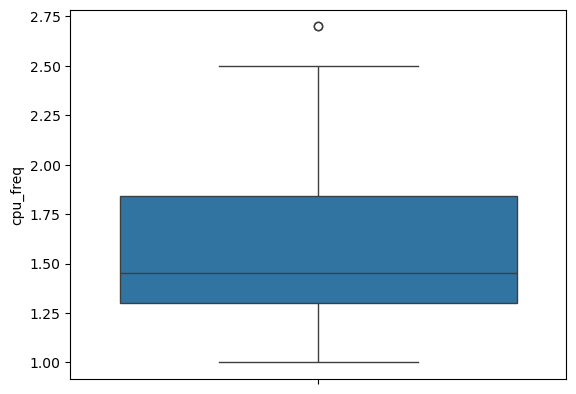

In [612]:
# Посмотрим боксплот
sns.boxplot(data=data['cpu_freq'])
plt.show()

In [614]:
#Посмотрим количество выбросов
ejection_values = ejection('cpu_freq')
ejection_count = ejection_values[2]
ejection_count

2

In [616]:
# Выше мы нашли число выбросов, перевернем условия, чтобы отфильтровать датасет без них
data = data[(data['cpu_freq'] < ejection('cpu_freq')[0]) & (data['cpu_freq'] > ejection('cpu_freq')[1])]
data = data.reset_index(drop=True)
data.head()

,product_id,price,sale,weight,resoloution,ppi,cpu_core,cpu_freq,internal_mem,ram,rearcam,front_cam,battery,thickness
0,203,2357,10,135.0,5.2,424,8,1.35,16.0,3.000,13.00,8.0,2610,7.4
1,880,1749,10,125.0,4.0,233,2,1.30,4.0,1.000,3.15,0.0,1700,9.9
2,40,1916,10,110.0,4.7,312,4,1.20,8.0,1.500,13.00,5.0,2000,7.6
3,99,1315,11,118.5,4.0,233,2,1.30,4.0,0.512,3.15,0.0,1400,11.0
4,880,1749,11,125.0,4.0,233,2,1.30,4.0,1.000,3.15,0.0,1700,9.9


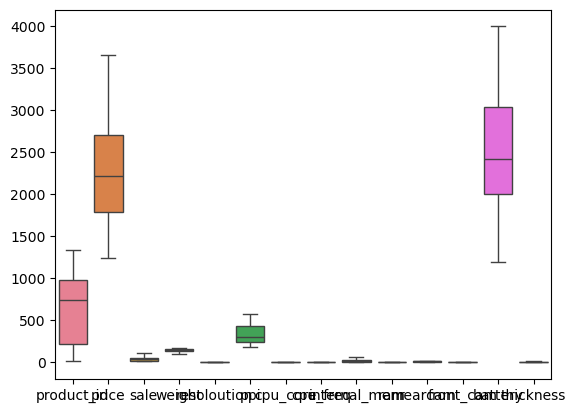

In [618]:
# Еще раз проверяем боксплот
sns.boxplot(data=data)
plt.show()

Выбросы удалены.

# 2. Анализ целевой переменной

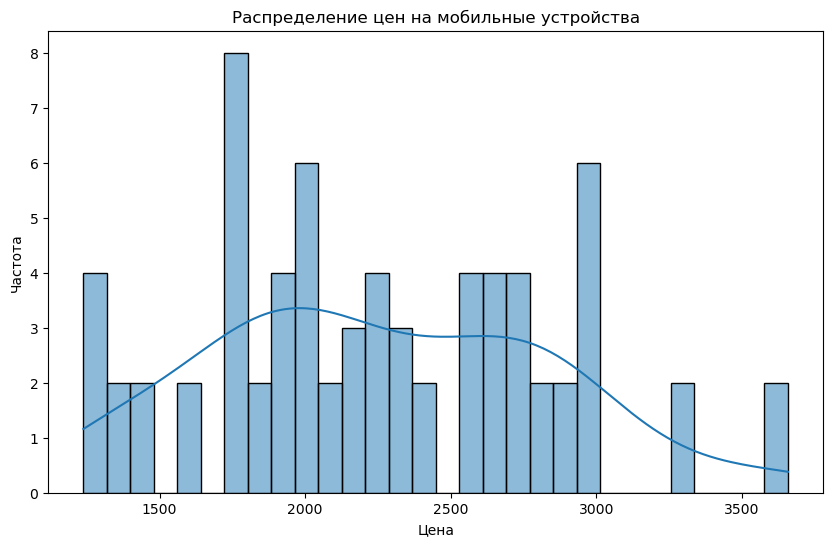

In [620]:
# Гистограмма распределения цен
plt.figure(figsize=(10, 6))
sns.histplot(data['price'], bins=30, kde=True)
plt.title('Распределение цен на мобильные устройства')
plt.xlabel('Цена')
plt.ylabel('Частота')
plt.show()

Видим, что в основном цены находятся в пределах 2000-3000.

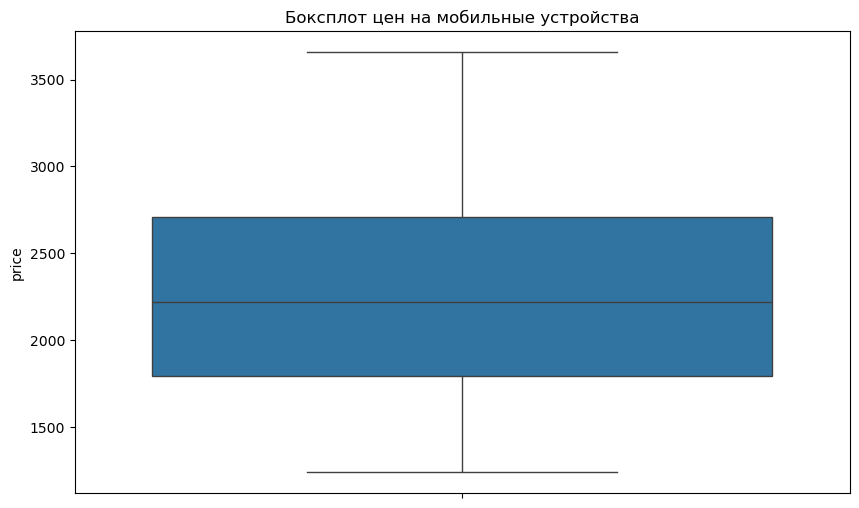

In [623]:
# Боксплот цен
plt.figure(figsize=(10, 6))
sns.boxplot(data['price'])
plt.title('Боксплот цен на мобильные устройства')
plt.show()

In [625]:
data['price'].describe()

count      70.000000
mean     2256.728571
std       584.747510
min      1238.000000
25%      1793.500000
50%      2216.000000
75%      2706.750000
max      3658.000000
Name: price, dtype: float64

Средняя цена - 2257, максимальная - 3658, минимальная - 1238.

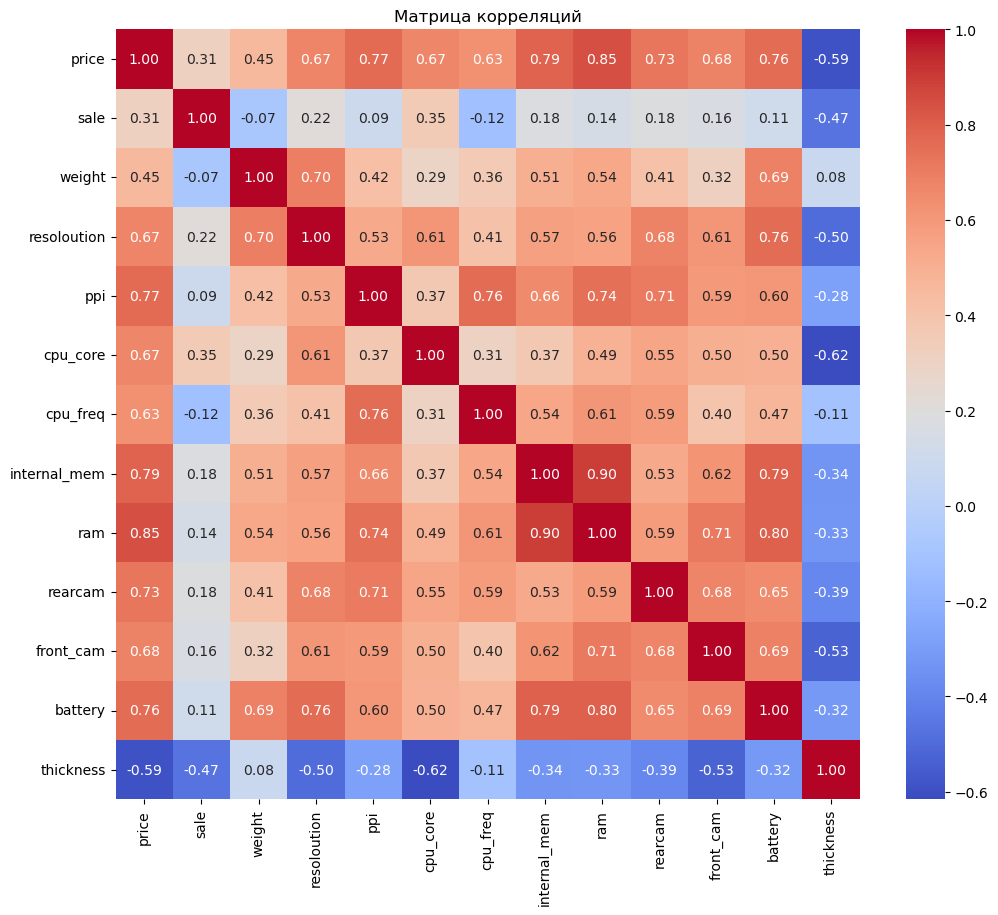

In [628]:
# Матрица корреляций
data = data.drop(['product_id'], axis = 1) # удалим столбец с id
plt.figure(figsize=(12, 10))
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Матрица корреляций')
plt.show()

In [630]:
# Корреляция признаков с целевой переменной
price_corr = corr_matrix['price'].sort_values(ascending=False)
print(price_corr)

price           1.000000
ram             0.846272
internal_mem    0.789467
ppi             0.766122
battery         0.756708
rearcam         0.725640
front_cam       0.680819
resoloution     0.674144
cpu_core        0.667760
cpu_freq        0.630386
weight          0.450925
sale            0.313635
thickness      -0.594578
Name: price, dtype: float64


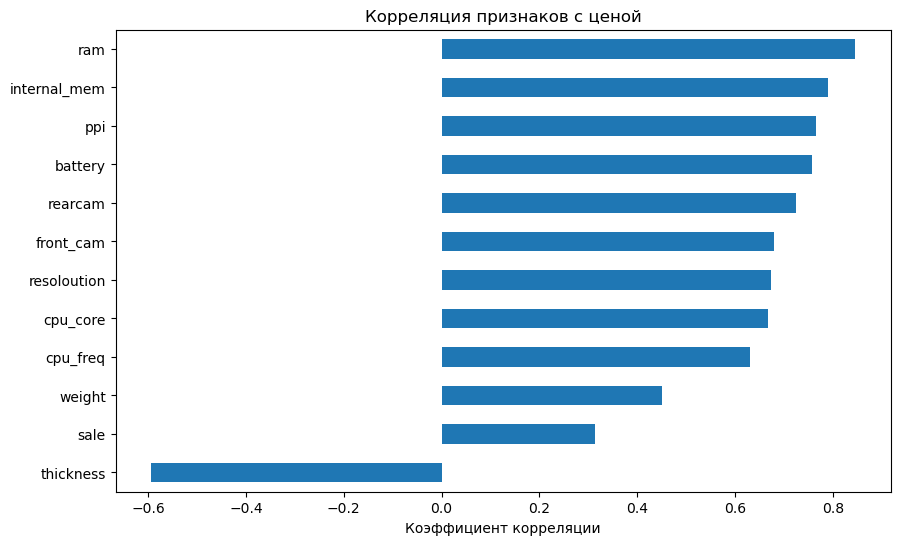

In [632]:
# Визуализация распределения признаков по корреляции с ценой
plt.figure(figsize=(10, 6))
price_corr.drop('price').sort_values().plot(kind='barh')
plt.title('Корреляция признаков с ценой')
plt.xlabel('Коэффициент корреляции')
plt.show()

Видим, что наибольшая корреляция у price с признаками ram, internal_mem, ppi, battery, rearcam.

# 3. Стандартизация

In [636]:
# Разделяем признаки
X = np.array(data.drop(['price'], axis=1).copy())
y = np.array(data['price'].copy())

In [638]:
# Разделим выборку на тестовую и тренировочную
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

In [640]:
scaler = StandardScaler()
x_train_st = scaler.fit_transform(x_train)
x_test_st = scaler.fit_transform(x_test)

In [642]:
f = col.copy()
del f[0]
del f[0]

# 4. Отбор факторов

In [645]:
data.corr()['price'].sort_values(ascending=False)

price           1.000000
ram             0.846272
internal_mem    0.789467
ppi             0.766122
battery         0.756708
rearcam         0.725640
front_cam       0.680819
resoloution     0.674144
cpu_core        0.667760
cpu_freq        0.630386
weight          0.450925
sale            0.313635
thickness      -0.594578
Name: price, dtype: float64

Связь цены со всеми параметрами, кроме количества продаж и веса, либо заметная, либо высокая. Для отбора факторов попробуем использовать пермутационную важность и значения коэффициента Шепли.

In [648]:
import shap

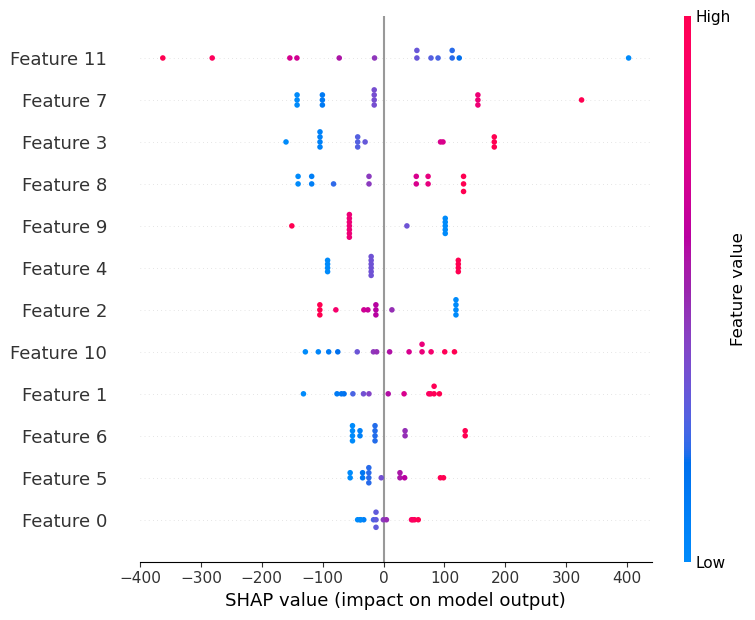

In [650]:
model = LinearRegression()
model.fit(x_train_st, y_train)

explainer = shap.Explainer(model, x_train_st)
shap_values = explainer(x_test_st)

shap.summary_plot(shap_values, x_test_st)

In [36]:
!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.4/108.4 kB 3.3 MB/s eta 0:00:00


In [51]:
perm = PermutationImportance(model, random_state=40).fit(x_test_st, y_test)
eli5.show_weights(perm, feature_names=f)

Weight,Feature
0.2936 ± 0.1780,thickness
0.1343 ± 0.0650,ram
0.0760 ± 0.0922,ppi
0.0609 ± 0.0758,cpu_core
0.0560 ± 0.1008,resoloution
0.0526 ± 0.0172,internal_mem
0.0202 ± 0.0244,front_cam
0.0137 ± 0.0354,battery
0.0073 ± 0.0136,weight
0.0069 ± 0.0131,rearcam


Результаты совпали. Будем строить линейную модель и постепенно добавлять в нее переменные по убыванию пермутационной важности. Странно, что у фактора "sale" самый низкий показатель коэффициента корреляцци, а влияние по Шепли и пермутационной важности на результат наибольшее.

# 5. Моделирование

Мы будем использовать следующие метрики:

- RMSE (Root Mean Squared Error) - корень из среднеквадратичной ошибки, чувствителен к большим ошибкам

- MAE (Mean Absolute Error) - средняя абсолютная ошибка, более устойчива к выбросам

- R² (R-squared) - коэффициент детерминации, показывает долю объясненной дисперсии

Обоснование:

RMSE и MAE хорошо подходят для задач регрессии, где важно оценить величину ошибки в абсолютных значениях

R² помогает понять, насколько хорошо модель объясняет вариативность данных

In [652]:
from sklearn.metrics import r2_score

In [658]:
# Посмотри коэффициент детерминации по признакам, отфильтрованным по Шепли и пермутационной важности
a = [11, 7, 3, 8, 9, 4, 2, 10, 1, 6, 5, 0]
r_2 = {}

In [660]:
for i in range(len(a)):
    x_tr = x_train_st[:, a[:i+1]]
    x_t = x_test_st[:, a[:i+1]]
    if i == 0:
        x_tr = x_tr.reshape(x_train_st.shape[0], 1)
        x_t = x_t.reshape(x_test_st.shape[0], 1)
    model = LinearRegression().fit(x_tr, y_train)
    prediction = model.predict(x_t)
    r = r2_score(y_test, prediction)
    r_2[a[i]] = r

In [662]:
r_2

{11: 0.4687566379894068,
 7: 0.9084584559419792,
 3: 0.9212978272279289,
 8: 0.9225052775596106,
 9: 0.9205983536225216,
 4: 0.9238912964334441,
 2: 0.9226628863282735,
 10: 0.9229778100303889,
 1: 0.9276843429215403,
 6: 0.9307232480347467,
 5: 0.94054976807233,
 0: 0.9439995408948292}

Итак, при включении в модель по порядку факторов коэффицент детерминации увеличивается. Пока наилучшей оделью явялется модель, включающая в качестве факторов все представленные факторы.

Посмотрим, какие результаты дадут модели, включающие только по одному фактору.

In [664]:
for i in range(len(a)):
    x_tr = x_train_st[:, a[i]]
    x_t = x_test_st[:, a[i]]
    x_tr = x_tr.reshape(x_train_st.shape[0], 1)
    x_t = x_t.reshape(x_test_st.shape[0], 1)
    model = LinearRegression().fit(x_tr, y_train)
    prediction = model.predict(x_t)
    r = r2_score(y_test, prediction)
    r_2[f[a[i]]] = r

In [666]:
r_2

{11: 0.4687566379894068,
 7: 0.9084584559419792,
 3: 0.9212978272279289,
 8: 0.9225052775596106,
 9: 0.9205983536225216,
 4: 0.9238912964334441,
 2: 0.9226628863282735,
 10: 0.9229778100303889,
 1: 0.9276843429215403,
 6: 0.9307232480347467,
 5: 0.94054976807233,
 0: 0.9439995408948292,
 'thickness': 0.4687566379894068,
 'ram': 0.7805220366273122,
 'ppi': 0.6434352016665528,
 'rearcam': 0.582350145272823,
 'front_cam': 0.5880462480707671,
 'cpu_core': 0.5460555800177351,
 'resoloution': 0.5017039857333514,
 'battery': 0.6184480660312142,
 'weight': 0.22930830050801176,
 'internal_mem': 0.6477351987443745,
 'cpu_freq': 0.49229731448661185,
 'sale': 0.16109485410694058}

Тут результаты уже ниже, поэтому данные модели нам не нужны, так как целью является построение модели, которая наилучшим образом описывает результат.

Попробовуем все возможные комбинации факторов.

In [670]:
from itertools import chain, combinations

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(list(combinations(s, r)) for r in range(len(s)+1))

In [672]:
s = list(powerset(a))

In [674]:
for subset in powerset(a):
    if not subset:  # Пропускаем пустое подмножество
        continue
    j = list(subset)
    if j == a[:len(j)]:  # Пропускаем тривиальные случаи (если нужно)
        continue
    x_tr = x_train_st[:, j]
    x_t = x_test_st[:, j]
    if len(j) == 1:
        x_tr = x_tr.reshape(x_train_st.shape[0], 1)
        x_t = x_t.reshape(x_test_st.shape[0], 1)
    model = LinearRegression().fit(x_tr, y_train)
    prediction = model.predict(x_t)
    r = r2_score(y_test, prediction)
    r_2[f'{subset}'] = r  # Сохраняем кортеж признаков и R²

In [676]:
# Находим комбинацию с максимальным R²
best_combo = max(r_2.items(), key=lambda x: x[1])
print(best_combo)

('(11, 7, 2, 1, 5, 0)', 0.9696825694601957)


R^2 получился выше. Таким образом, наилучшей моделью является модель, включающая факторы sale, weight, resoloution, cpu freq, ram, thickness.

### 1) Линейная регрессия

In [679]:
# Разделяем признаки
X = np.array(data.drop(['price', 'ppi',	'cpu_core',	'rearcam', 'front_cam',	'battery'], axis=1).copy())
y = np.array(data['price'].copy())

In [681]:
# Разделим выборку на тестовую и тренировочную
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

In [683]:
scaler = StandardScaler()
x_train_st = scaler.fit_transform(x_train)
x_test_st = scaler.fit_transform(x_test)

In [685]:
# Линейная регрессия
lr = LinearRegression()
lr.fit(x_train_st, y_train)
y_pred_lr = lr.predict(x_test_st)

In [687]:
# Оценка модели
print("Linear Regression:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lr))}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_lr)}")
print(f"R²: {r2_score(y_test, y_pred_lr)}")

Linear Regression:
RMSE: 123.42811820657413
MAE: 98.51130543399904
R²: 0.9691111239429915


In [689]:
# Прогнозирование
y_pred_lr

array([3392.47997968, 1921.803866  , 2846.11499004, 1450.02119911,
       2019.93065567, 1571.76669969, 2298.4859851 , 2060.59233616,
       1471.4783963 , 2534.14902373, 1683.87715895, 2498.68032473,
       2949.12102667, 2937.49835817])

### 2) Lasso

In [692]:
# Lasso
lasso = Lasso()
lasso_grid = GridSearchCV(lasso, parameters, cv=5, scoring='neg_mean_squared_error')
lasso_grid.fit(x_train_st, y_train)

# Лучшие параметры
print(f"Best alpha for Lasso: {lasso_grid.best_params_['alpha']}")

# Оценка лучшей модели
y_pred_lasso = lasso_grid.predict(x_test_st)
print("\nLasso Regression:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lasso))}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_lasso)}")
print(f"R²: {r2_score(y_test, y_pred_lasso)}")

Best alpha for Lasso: 10

Lasso Regression:
RMSE: 144.2713117377029
MAE: 116.38414140546308
R²: 0.9577979204762983


In [694]:
# Прогнозирование
y_pred_lasso

array([3347.58674503, 1917.64049192, 2835.26967576, 1489.60591432,
       2013.17217419, 1595.67460228, 2309.11674611, 2088.27421604,
       1505.70484498, 2512.60293048, 1705.09237789, 2498.03770425,
       2914.06260953, 2904.15896723])

### 3) Random Forest

In [697]:
# Random Forest
rf = RandomForestRegressor(random_state=50)
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
rf_grid = GridSearchCV(rf, rf_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
rf_grid.fit(x_train, y_train)

# Лучшие параметры
print(f"Best params for Random Forest: {rf_grid.best_params_}")

# Оценка лучшей модели
y_pred_rf = rf_grid.predict(x_test)
print("\nRandom Forest Regression:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_rf))}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_rf)}")
print(f"R²: {r2_score(y_test, y_pred_rf)}")

Best params for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}

Random Forest Regression:
RMSE: 168.8493529747745
MAE: 145.5235714285714
R²: 0.9421940301430226


In [698]:
# Прогнозирование
y_pred_rf

array([3328.405, 1881.095, 2839.445, 1418.985, 1857.19 , 1583.67 ,
       2380.16 , 2066.99 , 1377.73 , 2528.865, 1646.005, 2396.22 ,
       2735.085, 2735.085])

### 4) Gradient Boosting

In [702]:
# Gradient Boosting
gb = GradientBoostingRegressor(random_state=50)
gb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5]
}
gb_grid = GridSearchCV(gb, gb_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
gb_grid.fit(x_train, y_train)

# Лучшие параметры
print(f"Best params for Gradient Boosting: {gb_grid.best_params_}")

# Оценка лучшей модели
y_pred_gb = gb_grid.predict(x_test)
print("\nGradient Boosting Regression:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_gb))}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_gb)}")
print(f"R²: {r2_score(y_test, y_pred_gb)}")

Best params for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}

Gradient Boosting Regression:
RMSE: 104.77805871681392
MAE: 56.960975313649605
R²: 0.9777405419657766


In [703]:
# Прогнозирование
y_pred_gb

array([3655.86936083, 1774.34132617, 2856.6494565 , 1295.70231496,
       1982.32796767, 1500.10400127, 2420.86105425, 1979.13546935,
       1266.11965004, 2582.01901897, 1746.04923446, 2568.89170501,
       2754.8416176 , 2754.8416176 ])

               Model        RMSE         MAE        R²
3  Gradient Boosting  104.778059   56.960975  0.977741
0  Linear Regression  123.428118   98.511305  0.969111
1              Lasso  144.271312  116.384141  0.957798
2      Random Forest  168.849353  145.523571  0.942194


<Figure size 1200x800 with 0 Axes>

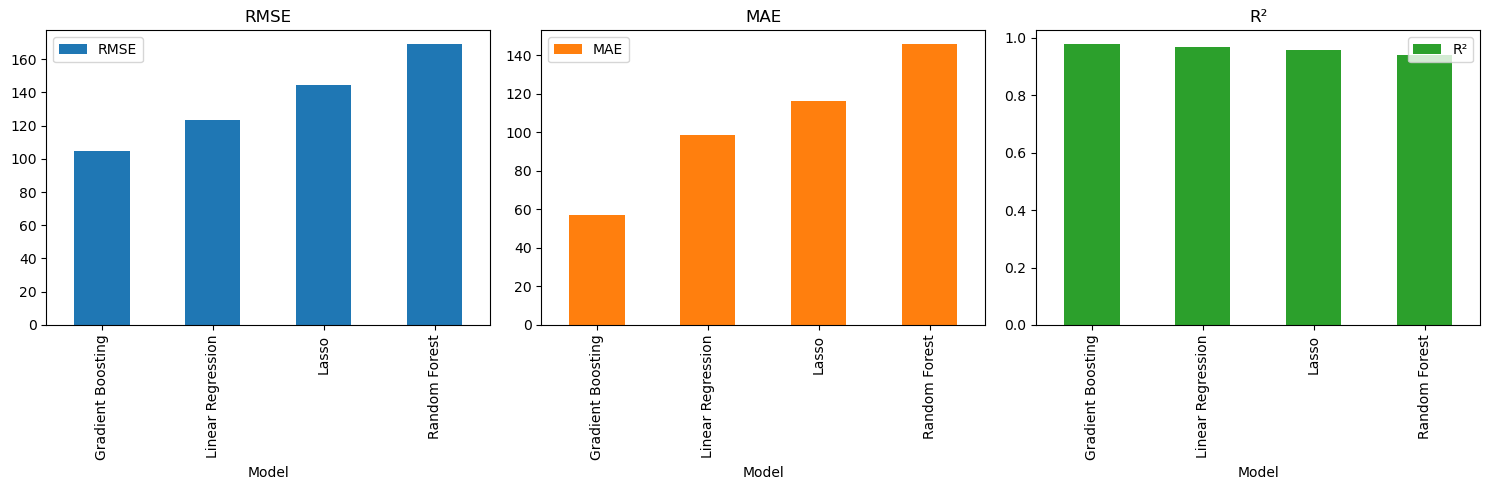

In [708]:
# Создаем DataFrame для сравнения моделей
models = ['Linear Regression', 'Lasso', 'Random Forest', 'Gradient Boosting']
rmse_scores = [
    np.sqrt(mean_squared_error(y_test, y_pred_lr)),
    np.sqrt(mean_squared_error(y_test, y_pred_lasso)),
    np.sqrt(mean_squared_error(y_test, y_pred_rf)),
    np.sqrt(mean_squared_error(y_test, y_pred_gb))
]
mae_scores = [
    mean_absolute_error(y_test, y_pred_lr),
    mean_absolute_error(y_test, y_pred_lasso),
    mean_absolute_error(y_test, y_pred_rf),
    mean_absolute_error(y_test, y_pred_gb)
]
r2_scores = [
    r2_score(y_test, y_pred_lr),
    r2_score(y_test, y_pred_lasso),
    r2_score(y_test, y_pred_rf),
    r2_score(y_test, y_pred_gb)
]

results_df = pd.DataFrame({
    'Model': models,
    'RMSE': rmse_scores,
    'MAE': mae_scores,
    'R²': r2_scores
})

# Сортируем по RMSE
results_df = results_df.sort_values(by='RMSE')
print(results_df)

# Визуализация сравнения моделей
plt.figure(figsize=(12, 8))
results_df.set_index('Model').plot(kind='bar', subplots=True, layout=(1, 3), figsize=(15, 5))
plt.tight_layout()
plt.show()

Построим еще дополнительно knn.

In [710]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

# Создаем модель KNN для регрессии
knn = KNeighborsRegressor()

# Параметры для подбора
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # 1 - манхэттенское расстояние, 2 - евклидово
}

# Настройка GridSearchCV для регрессии (используем отрицательное MSE как scoring)
grid_knn = GridSearchCV(knn, param_grid, cv=10, scoring='neg_mean_squared_error', return_train_score=False)
grid_knn.fit(x_train_st, y_train)

# Лучшие параметры
print(f"Best parameters for KNN: {grid_knn.best_params_}")

# Прогноз на тестовых данных
y_pred_knn = grid_knn.predict(x_test_st)

# Оценка модели
print("\nKNN Regression:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_knn))}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_knn)}")
print(f"R²: {r2_score(y_test, y_pred_knn)}")

Best parameters for KNN: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}

KNN Regression:
RMSE: 227.73461740912404
MAE: 202.21913517051226
R²: 0.894844499694246


In [712]:
# Прогнозирование
y_pred_knn

array([3283.40671284, 1945.89681065, 2831.45913836, 1440.14614874,
       1707.15319862, 1722.6136297 , 2202.03989716, 2152.34496796,
       1559.14323922, 2385.52480897, 1810.04442397, 2415.23183031,
       2712.37855463, 2710.92718697])

In [714]:
# Добавим результаты в таблицу сравнения
results_df.loc[len(results_df)] = [
    'KNN Regressor',
    np.sqrt(mean_squared_error(y_test, y_pred_knn)),
    mean_absolute_error(y_test, y_pred_knn),
    r2_score(y_test, y_pred_knn)
]

# Сортируем по RMSE
results_df = results_df.sort_values(by='RMSE')
print(results_df)

               Model        RMSE         MAE        R²
3  Gradient Boosting  104.778059   56.960975  0.977741
0  Linear Regression  123.428118   98.511305  0.969111
1              Lasso  144.271312  116.384141  0.957798
2      Random Forest  168.849353  145.523571  0.942194
4      KNN Regressor  227.734617  202.219135  0.894844


# Вывод:

Таким образом, из всех построенных моделей, наилучшей получилась модель градиента Gradient Boosting: R^2=0,98, а ошибки принимают наименьшие значения из представленных.

Прогноз цен на тестовой выборке: array([3655.86936083, 1774.34132617, 2856.6494565 , 1295.70231496,
       1982.32796767, 1500.10400127, 2420.86105425, 1979.13546935,
       1266.11965004, 2582.01901897, 1746.04923446, 2568.89170501,
       2754.8416176 , 2754.8416176 ])